In [1]:
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as cPickle
import xarray as xr

from driftutils import keep_in_domain as kid
from driftutils.utils import wrap_to_180

%matplotlib inline


def load_data(fname, pdir=None):
    if pdir:
        pname = os.path.basename(fname)
        pfile = os.path.join(pdir, pname)
        if os.path.exists(pfile):
            ds = load_pickle(pfile)
        else:
            with xr.load_dataset(fname) as ds:
                save_pickle(pfile, ds)
            return ds
    else:
        with xr.load_dataset(fname) as ds:
            return ds
    
def save_pickle(fname, data):
    print('Creating ' + os.path.basename(fname))
    with open(fname, 'wb') as handle:
        cPickle.dump(data, handle)

def load_pickle(fname):
    print('Loading ' + os.path.basename(fname))
    with open(fname, 'rb') as handle:
        loaded_data = cPickle.load(handle)
    return loaded_data

projdir = "/gpfs/fs7/dfo/dpnm/jeh326/projects/stokes_drift/input_data/SalishSea/"
outdir = os.path.join(projdir, "data_converted")

currs_fname = "Salish-Sea_2D-Wave-Fields_currents_20230217T00-20230224T1130.nc"
waves_fname = "Salish-Sea_2D-Wave-Fields_waves_20230217T00-20230224T1130.nc"
winds_fname = "Salish-Sea_2D-Wave-Fields_winds_20230217T00-20230224T1130.nc"

in_currs = load_data(os.path.join(projdir, "currents", currs_fname))
in_waves = load_data(os.path.join(projdir, "waves", waves_fname))
in_winds = load_data(os.path.join(projdir, "winds", winds_fname))

out_currs = os.path.join(outdir, "currents", currs_fname) 
out_waves = os.path.join(outdir, "waves", waves_fname) 
out_winds = os.path.join(outdir, "winds", winds_fname) 

In [29]:
def adjust_ds(ds):
    wrapped_lons = wrap_to_180(ds.longitude.values)
    wrapped_lons_actual_range = np.array([np.nanmin(wrapped_lons), np.nanmax(wrapped_lons)])

    new = ds.copy()
    new['longitude'] = wrapped_lons
    new_lon_attrs = ds.longitude.attrs

    new_lon_attrs['actual_range'] = wrapped_lons_actual_range 
    new_lon_attrs['valid_max'] = 180.0
    new_lon_attrs['valid_min'] = -180.0

    new['longitude'].attrs = new_lon_attrs

    #to also add depth to the file:
    ##new = new.expand_dims(dim='depth', axis=1)
    ##new["depth"] = [0]
    return new


#adjust_ds(in_currs).to_netcdf(out_currs)
#adjust_ds(in_waves).to_netcdf(out_waves)
#adjust_ds(in_winds).to_netcdf(out_winds)

#new = adjust_ds(in_currs)
#new = adjust_ds(in_winds)
new = adjust_ds(in_waves)

#adjusted_currs_ds = adjust_ds(in_currs)
#print(adjusted_currs_ds)
#print('')
#np.isnan(adjusted_currs_ds.ucur.values.flatten()).all()
#adjusted_currs_ds.to_netcdf(out_currs)

In [30]:
def set_up_map_plot(ax):
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'},
                 linewidth=2, color='gray', alpha=0.1, 
                 linestyle='-', zorder=1)
    return ax


def create_subplots_figure(nrows=1, ncols=1, map=False, fsize=None, ratio=1.5, axsize=6):
    """ratio is expected to be width/height so that a ratio of 2 will
    give a plot that is twice as wide as it is tall"""
    if not fsize:
        fsize = (ratio*(axsize*nrows), axsize*ncols)
    if map:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize,
                                subplot_kw={'projection': crs.PlateCarree()})
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=fsize)
    return fig, axs.flatten()

In [31]:
new

<xarray.Dataset>
Dimensions:    (time: 360, latitude: 661, longitude: 572)
Coordinates:
  * time       (time) datetime64[ns] 2023-02-17 ... 2023-02-24T11:30:00
  * latitude   (latitude) float32 48.0 48.0 48.01 48.01 ... 50.96 50.97 50.97
  * longitude  (longitude) float32 -126.0 -126.0 -126.0 ... -122.0 -122.0 -122.0
Data variables:
    uuss       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vuss       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/41)
    acknowledgement:               Fisheries & Oceans Canada, MEOPAR, ONC, Co...
    area:                          SoG_BCgrid_00500m
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    creator_email:                 gemmrich@uvic.ca
    creator_name:                  Salish Sea MEOPAR Project Contributors
    ...                            ...
    time_coverage_end:             2023-02-24T11:30:00Z
    time_coverage_start:           2023-02-17T00:00:00Z
    title:                         Forecast, Salish Sea, 2d Wave Fields, 30mi...
    WAVEWATCH_III_switches:        IS0 IC0 REF1 RWND DIST MPI UQ PR3 LN1 FLX0...
    WAVEWATCH_III_version_number:  5.16
    Westernmost_Easting:           234.0

In [24]:
times = new.time.values
lats = new.latitude.values
lons = new.longitude.values  # wrap_to_180(ss.longitude.values)
#ucurs = new.ucur.values
#vcurs = new.vcur.values
uwnd = new.uwnd.values
vwnd = new.vwnd.values

bbox = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
xv, yv = np.meshgrid(lons, lats)
dummy = np.ones([len(xv), len(xv[0])])
edge_lons, edge_lats = kid.find_edges(xv, yv, 0)

In [ ]:
fig, axs = create_subplots_figure(nrows=1, ncols=1, axsize=5)
ax = axs[0]
ax.plot(times, '-', color='black', linewidth=0.5)
ind = list(range(0, len(times)))
ax.plot(ind[::24], times[::24], 'o', color='b', markersize=3, label='every 12 hours')
ax.axhline(times[47], color='green', linestyle='--', label="first experiment start time")
ax.axhline(times[95], color='red', linestyle='--', label="last experiment start time")
ax.legend()

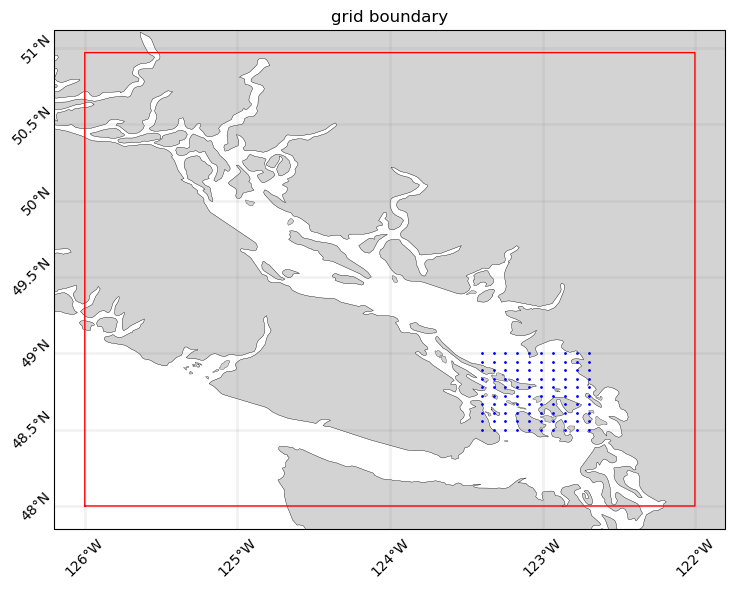

In [15]:
initial_lats = [48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49]
initial_lons = [-123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7]

fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True)
ax = axs[0]
set_up_map_plot(ax)
ax.set_title('grid boundary')

ax.plot(edge_lons, edge_lats, color='r', linestyle='-', linewidth=1)

ax.plot(initial_lons, initial_lats, 'o', color='b', markersize=1)

plt.tight_layout()

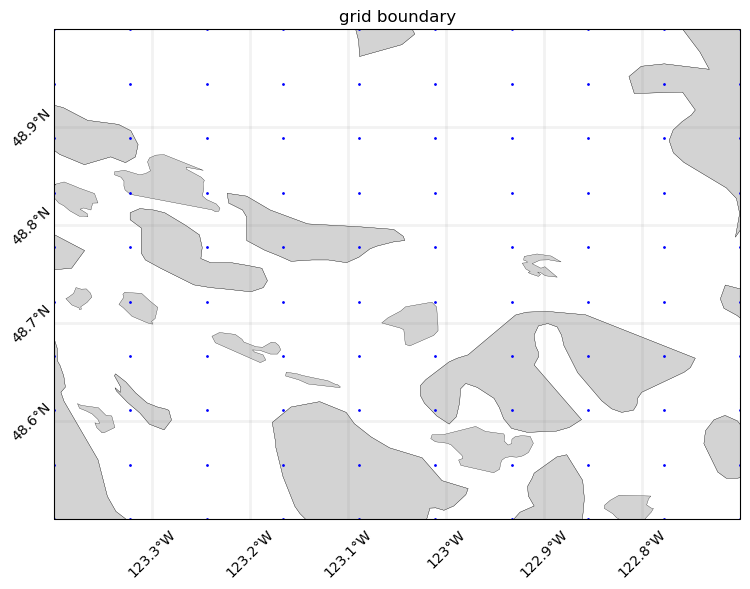

In [16]:
initial_lats = [48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.5, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.55555556, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.61111111, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.66666667, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.72222222, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.77777778, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.83333333, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.88888889, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 48.94444444, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49]
initial_lons = [-123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7, -123.4, -123.32222222, -123.24444444, -123.16666667, -123.08888889, -123.01111111, -122.93333333, -122.85555556, -122.77777778, -122.7]

fig, axs = create_subplots_figure(nrows=1, ncols=1, map=True)
ax = axs[0]
set_up_map_plot(ax)
ax.set_title('grid boundary')

ax.plot(edge_lons, edge_lats, color='r', linestyle='-', linewidth=1)

ax.plot(initial_lons, initial_lats, 'o', color='b', markersize=1)

#bbox_buff = [bbox[0]-1, bbox[1]+1, bbox[2]-1, bbox[3]+1]
#ax.set_extent(bbox_buff, crs=crs.PlateCarree())
bbox_ini = [-123.4, -122.7, 48.5, 49]
ax.set_extent(bbox_ini, crs=crs.PlateCarree())

plt.tight_layout()